In [1]:
import lightgbm as lgb, catboost as cat

In [2]:
import pandas as pd

In [3]:
import numpy as np
import random

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [6]:
#pd.read_csv("data_phase_one/coords.csv", header=None)

In [8]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [9]:
#y = train_df["target"]

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [12]:
X_train = train_data.drop(columns=["target"]).values
X_val = val_data.drop(columns=["target"]).values

y_train = train_data["target"].values
y_val = val_data["target"].values

In [13]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "max_depth": 8,
    'num_leaves': 255,
    "learning_rate": 0.001,
    "n_estimators": 1000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "device": "cpu"
}

lgb_model = lgb.LGBMRegressor(**params, random_state=42)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)])

LGBMRegressor(device='cpu', learning_rate=0.001, max_depth=8, metric='l2',
              n_estimators=1000, num_leaves=255, objective='regression',
              random_state=42, verbose=-1)

In [14]:
catb_model = cat.CatBoostRegressor(
task_type="GPU",
devices='1',
reg_lambda=0.438, learning_rate=0.01,
max_depth=8, min_data_in_leaf=50,
n_estimators=1000, verbose=1,
objective='RMSE', random_state=1)

In [15]:
catb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)])

0:	learn: 0.6101302	test: 0.6099027	best: 0.6099027 (0)	total: 25.7ms	remaining: 25.6s
1:	learn: 0.6043407	test: 0.6041141	best: 0.6041141 (1)	total: 47.7ms	remaining: 23.8s
2:	learn: 0.5986103	test: 0.5983864	best: 0.5983864 (2)	total: 69.9ms	remaining: 23.2s
3:	learn: 0.5929395	test: 0.5927181	best: 0.5927181 (3)	total: 91.8ms	remaining: 22.9s
4:	learn: 0.5873210	test: 0.5871023	best: 0.5871023 (4)	total: 113ms	remaining: 22.6s
5:	learn: 0.5817631	test: 0.5815464	best: 0.5815464 (5)	total: 136ms	remaining: 22.6s
6:	learn: 0.5762551	test: 0.5760408	best: 0.5760408 (6)	total: 160ms	remaining: 22.6s
7:	learn: 0.5708063	test: 0.5705939	best: 0.5705939 (7)	total: 183ms	remaining: 22.6s
8:	learn: 0.5654088	test: 0.5651995	best: 0.5651995 (8)	total: 207ms	remaining: 22.8s
9:	learn: 0.5600529	test: 0.5598447	best: 0.5598447 (9)	total: 229ms	remaining: 22.6s
10:	learn: 0.5547435	test: 0.5545368	best: 0.5545368 (10)	total: 251ms	remaining: 22.6s
11:	learn: 0.5494900	test: 0.5492831	best: 0.549

In [16]:
#test_data = read_merge_data("test")

In [31]:
pred_lgb = lgb_model.predict(X_val[:200])
pred_catb = catb_model.predict(X_val[:200])

In [32]:
print("lgbm error:", np.linalg.norm(y_val[:200]-pred_lgb))
print("catboost error:", np.linalg.norm(y_val[:200]-pred_catb))

lgbm error: 2.839031057030926
catboost error: 0.34972709184434214


In [33]:
import matplotlib.pyplot as plt

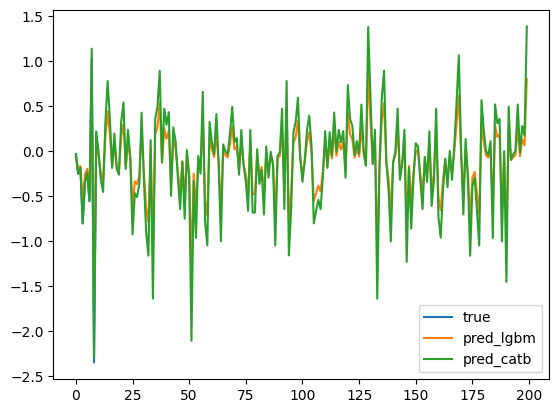

In [34]:
plt.plot(y_val[:10])
plt.plot(pred_lgb)
plt.plot(pred_catb)
plt.legend(["true", "pred_lgbm", "pred_catb"])
plt.show()

In [21]:
import joblib

In [22]:
joblib.dump(lgb_model, "./trained_models/lgb_model.joblib")

['./trained_models/lgb_model.joblib']

In [23]:
joblib.dump(catb_model, "./trained_models/catb_model.joblib")

['./trained_models/catb_model.joblib']